### ❷ 問題設定とデータの確認
必要なライブラリのインポート

In [1]:
from IPython.core.display import display
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pulp
from itertools import product, combinations_with_replacement
from joblib import Parallel, delayed

/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_62418/3303897114.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


問題設定に必要な数値群

In [2]:
np.random.seed(10)
num_places = 10  # 地点の数
num_days = 30  # 計画の対象日数
num_requests = 120  # 荷物の数

mean_travel_time_to_destinations = 100  # 自社から平均的に100分程度距離に配達先候補があるとしてデータを作る．
H_regular = 8*60  # 8時間が定時労働
H_max_overtime = 3*60  # 残業3時間まで
c = 3000//60  # 残業による経費60分 3000円
W = 4000  # 4 トントラックを利用
delivery_outsourcing_unit_cost = 4600  # 100kg あたり4600円の配送費用
delivery_time_window = 3  # 連続する3日が配達可能な候補日となる．
avg_weight = 1000  # 荷物の平均的な重さを1000kgとする


In [3]:
K = range(num_places)  # 地点の集合
o = 0  # 自社拠点を表す地点
K_minus_o = K[1:]  # 配達先の集合
_K = np.random.normal(0, mean_travel_time_to_destinations, size=(len(K), 2))  # 各地点の座標を設定
_K[o,:] = 0  # 自社拠点は原点とする．
t = np.array([[np.floor(np.linalg.norm(_K[k] - _K[l])) for k in K] for l in K])  # 各地点間の移動時間行列(分)

D = range(num_days)  # 日付の集合
R = range(num_requests)  # 荷物の集合
k = np.random.choice(K_minus_o, size=len(R))  # k[r] は 荷物 r の配送先を表す
d_0 = np.random.choice(D, size=len(R))  # d_0[r] は荷物 r の配送可能日の初日を表す
d_1 = d_0 + delivery_time_window-1   # d_1[r] は荷物 r の配送可能日の最終日を表す
w = np.floor(np.random.gamma(10, avg_weight/10, size=len(R)))  # w[r] が荷物 r の重さ(kg)を表す
f = np.ceil(w/100)*delivery_outsourcing_unit_cost  # f[r] が荷物 r の外部委託時の配送料を表す

各種値の可視化

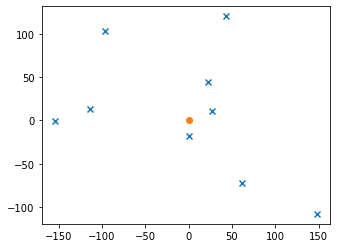

In [4]:
a = plt.subplot()
a.scatter(_K[1:,0], _K[1:,1], marker='x')
a.scatter(_K[0,0], _K[0,1], marker='o')
a.set_aspect('equal')
plt.show()

(array([ 0.,  0.,  0.,  0.,  2.,  9.,  7., 11., 14., 12., 22., 14., 14.,
         9.,  2.,  1.,  2.,  0.,  1.,  0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000.]),
 <BarContainer object of 20 artists>)

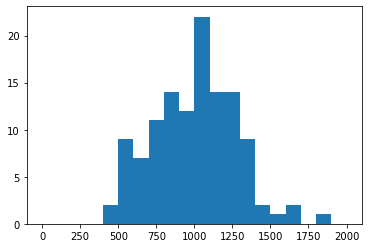

In [5]:
plt.hist(w, bins=20, range=(0,2000))

### ❸ 日ごとのスケジュールの列挙

In [6]:
def simulate_route(z):
    # enumerate_routes の中でのみ用いる関数
    # z は k_minus_o の部分集合を意味するは長さnum_places の 0 または1の値のリストで、
    # z[k] == 1 (k in K) が k への訪問があることを意味する．

    if z[0] == 0:  # 自社拠点を通らない移動経路は不適切なので None を返し，後段で除去する．
        return None

    # 巡回セールスマン問題を解く
    daily_route_prob = pulp.LpProblem(sense=pulp.LpMinimize)

    # k から l への移動の有無
    x = {
        (k, l): 
            pulp.LpVariable(f'x_{k}_{l}', cat='Binary') if k != l else pulp.LpAffineExpression()
        for k, l in product(K, K)
    }

    # MTZ 定式化のための補助変数
    u = {
        k: pulp.LpVariable(
            f'u_{k}', 
            lowBound=1, 
            upBound=len(K) - 1,
        )
        for k in K_minus_o
    }
    # MTZ 定式化の補助変数の説明では訪問順序であることを意識して u[0] を変数かのように書いたが，
    # 実際には 0 に固定されている値であるので，ここでは変数としては u[0] は定義しない．    

    h = pulp.LpVariable(f'h', lowBound=0, cat='Continuous')

    # 移動の構造
    for l in K:
        daily_route_prob += (
            pulp.lpSum([x[k,l] for k in K]) <= 1
        )

    for l in K:
        if z[l] == 1:
            # z で l への訪問が指定されている場合，必ず訪問するようにする．
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 1
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 1
            )

        else:
            # z で l への訪問が禁止されている場合，訪問ができないように x に制約を入れる
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 0
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 0                
            )
            

    # サイクルの除去．
    for k, l in product(K_minus_o, K_minus_o):
        daily_route_prob += (
            u[k] + 1 <= u[l] + len(K_minus_o) * (1 - x[k, l])
        )    

    # 労務関係．(巡回セールスマン問題にはない制約だが，これが満たされない場合実行不可能としたいので追加)
    travel = pulp.lpSum([t[k, l]*x[k, l] for k, l in product(K, K)]) # 移動時間
    daily_route_prob += (travel - H_regular <= h)
    daily_route_prob += (h <= H_max_overtime)

    # 目的関数
    daily_route_prob += travel
    daily_route_prob.solve()

    return {
        'z': z,
        'route': { # k から l への移動の有無を辞書で保持
            (k, l): x[k, l].value() 
            for k, l in product(K, K)
        },
        'optimal': daily_route_prob.status == 1,
        '移動時間': travel.value(),
        '残業時間': h.value(),
    }

def enumerate_routes():
    # 移動経路を列挙する    
    # joblib を用いて計算を並列化(16並列)して，K_minus_o のすべての部分集合に対する最短の移動経路を列挙
    # これは次のコードを並列化したもの．
    # routes = []
    # for z in product([0,1], repeat=len(K)):
    #     routes.append(simulate_route(z))
    routes = Parallel(n_jobs=16)(
        [delayed(simulate_route)(z) for z in product([0,1], repeat=len(K))]
    )
    
    # 結果が None のもの（自社拠点を通らないもの）を除去
    routes = pd.DataFrame(filter(lambda x: x is not None, routes))
    
    # 結果が Optimal でないもの（ここでは移動時間が長すぎて実行不能となるもの）を除去
    routes = routes[routes.optimal].copy()
    return routes

routes_df = enumerate_routes()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shota/opt/miniconda3/envs/mathopt/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/55d170e017ad48db83c5cb0cdd8288a0-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/55d170e017ad48db83c5cb0cdd8288a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 118 COLUMNS
At line 976 RHS
At line 1090 BOUNDS
At line 1199 ENDATA
Problem MODEL has 113 rows, 100 columns and 578 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shota/opt/miniconda3/envs/

In [7]:
routes_df

,z,route,optimal,移動時間,残業時間
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,366.0,0.0
2,"(1, 0, 0, 0, 0, 0, 0, 0, 1, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,228.0,0.0
3,"(1, 0, 0, 0, 0, 0, 0, 0, 1, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,585.0,105.0
4,"(1, 0, 0, 0, 0, 0, 0, 1, 0, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,100.0,0.0
5,"(1, 0, 0, 0, 0, 0, 0, 1, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,430.0,0.0
...,...,...,...,...,...
486,"(1, 1, 1, 1, 1, 0, 0, 1, 1, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,558.0,78.0
488,"(1, 1, 1, 1, 1, 0, 1, 0, 0, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,614.0,134.0
490,"(1, 1, 1, 1, 1, 0, 1, 0, 1, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,617.0,137.0
492,"(1, 1, 1, 1, 1, 0, 1, 1, 0, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,626.0,146.0


In [8]:
def is_OK(requests):
    # 指定された荷物の配送が重量制約のもとで可能かを確認する
    # 可能である場合は配送を実行できる最短の移動経路のインデックス (routes_df におけるもの) とその所要時間を返す
    # 不可能であれば，False を返す
    # requests: R に含まれるリストで，配送する荷物の一覧を表す
    
    weight = sum([w[r] for r in requests])
    if weight > W:
        return False
    
    # ルート関係
    best_route_idx = None
    best_hours = sys.float_info.max
    for route_idx, row in routes_df.iterrows():
        all_requests_on_route = all([row.z[k[r]] == 1 for r in requests])
        if all_requests_on_route and row.移動時間 < best_hours:
            best_route_idx = route_idx
            best_hours = row.移動時間
    if best_route_idx is None:
        return False
    else:
        return best_route_idx, best_hours

    
def _enumerate_feasible_schedules(requests_cands, current_idx_set, idx_to_add, res):
    # R に含まれるリスト requests_cands を候補として
    # current_idx_set で指定される荷物に加えて配送することができる
    # requests_cands[idx_to_add:] の部分集合をすべて列挙する．（再帰的に計算する）
    # 配送可能な荷物の集合は， リスト res に追加される
    
    # idx_set_to_check = current_idx_set + [idx_to_add] で指定される
    # 荷物が配送可能かを確認する．
    idx_set_to_check = current_idx_set + [idx_to_add]
    next_idx = idx_to_add + 1
    is_next_idx_valid = next_idx < len(requests_cands)
    requests = [requests_cands[i] for i in idx_set_to_check]
    is_ok = is_OK(requests)
    
    if is_ok:
        # idx_set_to_check で指定される荷物が配送可能であれば，
        # その配送に用いられる移動経路の情報を記録する．
        best_route_idx, best_hour = is_ok
        res.append(
            {
                'requests': [requests_cands[i] for i in idx_set_to_check], 
                'route_idx': best_route_idx, 
                'hours': best_hour
            }
        )
        if is_next_idx_valid:
            # さらに荷物を追加できるかを確認する．
            _enumerate_feasible_schedules(requests_cands, idx_set_to_check, next_idx, res)
    if is_next_idx_valid:
        # idx_to_add をスキップして， next_idx 以降の荷物が追加できるかを確認する．
        _enumerate_feasible_schedules(requests_cands, current_idx_set, next_idx, res)

        
def enumerate_feasible_schedules(d: int):
    # _enumerate_feasible_schedules を用いて d 日に考慮すべきスケジュールを列挙する．
    
    # 配送日指定に合うものだけを探索する
    requests_cands = [r for r in R if d_0[r] <= d <= d_1[r]]

    # res に d 日の実行可能なスケジュールを格納する
    res = [
        {'requests': [], 'route_idx': 0, 'hours': 0}
    ]
    _enumerate_feasible_schedules(requests_cands, [], 0, res)

    # res を DataFrame 型にして後処理に必要な値を計算
    feasible_schedules_df = pd.DataFrame(res)
    feasible_schedules_df['overwork'] = (feasible_schedules_df.hours - H_regular).clip(0)
    feasible_schedules_df['requests_set'] = feasible_schedules_df.requests.apply(set)

    # feasible_schedules_df のうち，不要なスケジュールを削除する．
    # すなわちあるスケジュールが別のスケジュールに対して
    #   - 配送する荷物の集合の包含関係での比較
    #   - 残業時間の比較
    # の2つの比較で同時に負けている場合には，そのスケジュールは利用価値がないため，破棄する．
    
    # 残すスケジュールの index の候補
    idx_cands = set(feasible_schedules_df.index)
    # 破棄するスケジュールの index の候補
    dominated_idx_set = set()
    for dominant_idx in feasible_schedules_df.index:
        for checked_idx in feasible_schedules_df.index:
            # 配送する荷物の集合の包含関係での比較
            requests_strict_dominance = (
                feasible_schedules_df.requests_set.loc[checked_idx] < 
                feasible_schedules_df.requests_set.loc[dominant_idx] 
            ) 
            # 残業時間の比較
            overwork_weak_dominance = (
                feasible_schedules_df.overwork.loc[checked_idx] >=
                feasible_schedules_df.overwork.loc[dominant_idx]                 
            )
            if requests_strict_dominance and overwork_weak_dominance:
                dominated_idx_set.add(checked_idx)
                
    nondominated_idx_set = idx_cands - dominated_idx_set
    nondominated_feasible_schedules_df = feasible_schedules_df.loc[nondominated_idx_set, :]
    return nondominated_feasible_schedules_df

_schedules = Parallel(n_jobs=16)([delayed(enumerate_feasible_schedules)(d) for d in D] )
feasible_schedules = dict(zip(D, _schedules))


/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_62418/2789198751.py:101: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_62418/2789198751.py:101: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_62418/2789198751.py:101: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_62418/2789198751.py:101: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9/wtlgcx3x4k10tkcdwcls97_40000gn/T/ipykernel_62418/2789198751.py:101: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/var/folders/f9

KeyboardInterrupt: 

In [ ]:
print('一日の最大スケジュール候補数:', max([len(df) for df in feasible_schedules.values()]))
print('スケジュール候補数の合計:',sum([len(df) for df in feasible_schedules.values()]))

一日の最大スケジュール候補数: 939
スケジュール候補数の合計: 8430


### ❹ 問題を解く

<!-- ### 決定変数
* $z_{dq} \in \{0, 1\} \ (d\in[D], q \in \{0, 1\})$
  * どのルートを採用するか 
* $y_{dr} \in \{0, 1\} \ (d\in[D], r \in R)$
  * 自社トラックによる配送を表す変数．
* $h_d \in \mathbb{R}_+ \space(d \in [D])$
  * 残業時間を表す補助変数
 -->

In [10]:
prob = pulp.LpProblem(sense=pulp.LpMinimize)

# ■ 変数
# 日毎にどの配送計画を採用するか
z = {}
for d in D:
    for q in feasible_schedules[d].index:
        z[d, q] = pulp.LpVariable(f'z_{d}_{q}', cat='Binary')

# 配送を外注するかどうかの補助変数
y = {
    r: pulp.LpVariable(f'y_{r}', cat='Continuous', lowBound=0, upBound=1)
    for r in R
}   

# ■ 制約・目的関数定義の準備
# 荷物 r の配送の回数を y, z の言葉で表現しておく
deliv_count = {r: pulp.LpAffineExpression() for r in R}
for d in D:
    for q in feasible_schedules[d].index:
        for r in feasible_schedules[d].loc[q].requests:
            deliv_count[r] += z[d, q]

# 日付 d の残業時間を y, z の言葉で表現しておく
h = {
    d: pulp.lpSum(
        z[d, q] * feasible_schedules[d].overwork.loc[q]
        for q in feasible_schedules[d].index
    )
    for d in D
}

# ■ 制約
# 1日1つのスケジュールを選択する
for d in D: 
    prob += (
        pulp.lpSum(z[d, q] for q in feasible_schedules[d].index) == 1
    )

# y が外部委託による配送を表すように
for r in R:
    prob += (
        y[r] >= 1 - deliv_count[r]
    )
    
# ■ 目的関数
obj_overtime = pulp.lpSum([c * h[d] for d in D])
obj_outsorcing = pulp.lpSum(
    [f[r] * y[r] for r in R]
)

obj_total = obj_overtime + obj_outsorcing
prob += obj_total    


# ■ 求解
prob.solve()

1

### ❺ 得られた解の確認

In [11]:
# 日毎に可視化
def visualize_route(d):
    for q in feasible_schedules[d].index:
        if z[d, q].value() > 0.5:
            route_summary = feasible_schedules[d].loc[q]   
            route_geography = routes_df.loc[route_summary.route_idx]   
            break
            
    # 背景
    a = plt.subplot()
    a.scatter(_K[1:,0], _K[1:,1], marker='x')
    a.scatter(_K[0,0], _K[0,1], marker='o')
    
    # 移動経路
    motions = [(k_from, k_to) for (k_from, k_to), used in route_geography.route.items() if used > 0]
    for k_from, k_to in motions:
        p_from = _K[int(k_from)]
        p_to =  _K[int(k_to)]
        a.arrow(
            *p_from, *(p_to-p_from), 
            head_width=3,
            length_includes_head=True,
            overhang=0.5,
            color='gray',
            alpha=0.5
        )
        
        requests_at_k_to = [r for r in route_summary.requests if k[r] == k_to]      
        a.text(*p_to, ' '.join([str(r) for r in requests_at_k_to]))
        
    plt.title(f'Schedule for day: {d}')
    plt.show()


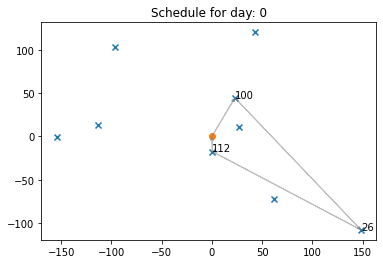

In [12]:
# 0日目のスケジュール
visualize_route(0)

In [13]:
requests_summary_df = pd.DataFrame(
    [{
        'outsourced': y[r].value(),
        'weight': w[r],
        'freight': f[r],
        'location': k[r],
        'distance_from_o': t[k[r], o]
    } for r in R]
)
requests_summary_df

,outsourced,weight,freight,location,distance_from_o
0,0.0,1147.0,55200.0,2,95.0
1,0.0,1166.0,55200.0,5,127.0
2,0.0,588.0,27600.0,3,28.0
3,0.0,770.0,36800.0,7,50.0
4,0.0,1836.0,87400.0,8,114.0
...,...,...,...,...,...
115,0.0,1250.0,59800.0,5,127.0
116,0.0,1222.0,59800.0,1,154.0
117,0.0,956.0,46000.0,3,28.0
118,0.0,1088.0,50600.0,9,183.0


In [14]:
requests_summary_df.groupby('outsourced')[['weight', 'freight', 'distance_from_o']].agg('mean')

,weight,freight,distance_from_o
outsourced,,,
0.0,1012.845455,48718.181818,106.609091
1.0,955.200000,45080.000000,121.700000


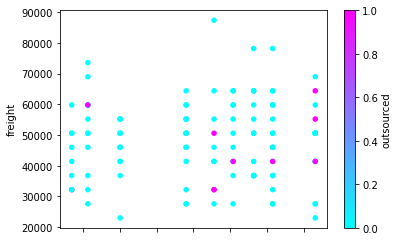

In [15]:
requests_summary_df.plot.scatter(x='distance_from_o', y='freight', c='outsourced', cmap='cool')
plt.show()